# Dependencies

In [1]:
work_dir = "/home/spaka002/NSF_REU_2024/"

In [2]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [4]:
data_folder = f"{work_dir}classification_datasets/"
meta_data_folder = f"{work_dir}meta_datasets/"

# Load Tensor

In [5]:
original_tensor = None
for_queries = False

Query Tensors

In [6]:
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/AND_AND_801.pt")
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/AND_OR_801.pt")
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/OR_AND_801.pt")
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/OR_OR_801.pt")

In [7]:
if (original_tensor is not None):
    original_tensor = (original_tensor - original_tensor.min())/(original_tensor.max() - original_tensor.min())
    for_queries = True

Hyperparameter Tensors

In [8]:
# original_tensor = torch.load(f"{meta_data_folder}GB_car_evaluation_709.pt")
# original_tensor = torch.load(f"{meta_data_folder}SVM_spambase_708.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Particle_ID_717.pt")
original_tensor = torch.load(f"{meta_data_folder}FCNN_Spambase_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Glass_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_car_evaluation_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_car_evaluation_719.pt")
# original_tensor = torch.load(f"{meta_data_folder}RF_Alzheimers_805.pt")

In [9]:
# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_car_727.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_car_727.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_car_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_car_730.pt")

# tensor1 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_glass_728.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_glass_728.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_glass_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_glass_730.pt")

# tensor2 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_bodyPerformance_731.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_bodyPerformance_731.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_bodyPerformance_731.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_bodyPerformance_731.pt")

# tensor3 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_Dermatology_802.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_Dermatology_802.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_Dermatology_802.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_Dermatology_802.pt")

# tensor4 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# original_tensor = torch.stack((tensor1, tensor2, tensor3, tensor4))

# del tensor1, tensor2, tensor3, tensor4

In [10]:
print(f"Tensor shape: {original_tensor.shape}")
total_cells = 1
for s in original_tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([6, 5, 8, 6])
1440 total cells in tensor.


# Train & Evaluate

In [11]:
num_epochs = 10000
batch_size = 256
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

ranks = [1, 2, 3, 5, 7, 10, 15, 20, 25]

In [12]:
portion = 0.05

In [13]:
costco_MAE = list()
cpd_MAE = list()
tuckER_MAE = list()

for rank in ranks:
        
        it_costco_MAE = list()
        it_cpd_MAE = list()
        it_tuckER_MAE = list()
        
        print(f"Rank {rank} iteration:", end = " ")
        for it in range(1, num_iterations+1):
                
                sparse_tensor = get_sparse_tensor(t = original_tensor.clone(),
                                                  portion = portion,
                                                  verbose = False)
                                                                        
                cpd = train_tensor_completion(model_type = 'cpd',
                                        train_indices = sparse_tensor.indices().t(),
                                        train_values = sparse_tensor.values(),
                                        tensor_size = sparse_tensor.size(),
                                        rank = rank, 
                                        num_epochs = num_epochs, 
                                        batch_size = batch_size,
                                        lr=lr, 
                                        wd=wd, 
                                        early_stopping = True,
                                        flags = 20,
                                        verbose = False,
                                        val_size = val_size,
                                        for_queries = for_queries)
                
                
                it_cpd_MAE += [get_unique_MAE(cpd,
                                                full_t = original_tensor,
                                                sparse_t = sparse_tensor)]       
                
                del cpd
                
                costco = train_tensor_completion(model_type = 'costco',
                                                        train_indices = sparse_tensor.indices().t(),
                                                        train_values = sparse_tensor.values(),
                                                        tensor_size = sparse_tensor.size(),
                                                        rank = rank, 
                                                        num_epochs = num_epochs, 
                                                        batch_size = batch_size,
                                                        lr=lr, 
                                                        wd=wd, 
                                                        early_stopping = True,
                                                        flags = 20,
                                                        verbose = False,
                                                        val_size = val_size,
                                                        convert_to_cpd=False,
                                                        for_queries = for_queries)
                
                it_costco_MAE += [get_unique_MAE(costco,
                                                full_t = original_tensor,
                                                sparse_t = sparse_tensor)]       
                
                del costco
                                        
                tuckER = train_tensor_completion(model_type = 'tuckER',
                                                train_indices = sparse_tensor.indices().t(),
                                                train_values = sparse_tensor.values(),
                                                tensor_size = sparse_tensor.size(),
                                                rank = rank, 
                                                num_epochs = num_epochs, 
                                                batch_size = batch_size,
                                                lr=lr, 
                                                wd=wd, 
                                                tucker_in_drop = 0.15,
                                                tucker_hidden_drop = 0.25,
                                                early_stopping = True,
                                                flags = 20,
                                                verbose = False,
                                                val_size = val_size,
                                                convert_to_cpd=False,
                                                for_queries = for_queries)
                
                it_tuckER_MAE += [get_unique_MAE(tuckER,
                                                full_t = original_tensor,
                                                sparse_t = sparse_tensor)]       
                
                del tuckER

                if (it == num_iterations): print(it)
                else: print(it, end = ", ")

        costco_MAE += [it_costco_MAE]
        cpd_MAE += [it_cpd_MAE]
        tuckER_MAE += [it_tuckER_MAE]

        del it_costco_MAE, it_cpd_MAE, it_tuckER_MAE

cpd_MAE =    np.array(cpd_MAE)
costco_MAE = np.array(costco_MAE)
tuckER_MAE = np.array(tuckER_MAE)

print("\nAll done!")

Rank 1 iteration: 1, 2, 3, 4, 5
Rank 2 iteration: 1, 2, 3, 4, 5
Rank 3 iteration: 1, 2, 3, 4, 5
Rank 5 iteration: 1, 2, 3, 4, 5
Rank 7 iteration: 1, 2, 3, 4, 5
Rank 10 iteration: 1, 2, 3, 4, 5
Rank 15 iteration: 1, 2, 3, 4, 5
Rank 20 iteration: 1, 2, 3, 4, 5
Rank 25 iteration: 1, 2, 3, 4, 5

All done!


In [14]:
cpd_MAE =    np.array(cpd_MAE)
costco_MAE = np.array(costco_MAE)
tuckER_MAE = np.array(tuckER_MAE)

In [15]:
all_MAEs = np.array([cpd_MAE, costco_MAE, tuckER_MAE])
labels = ['CPD', 'CoSTCo', 'TuckER']

avgs = all_MAEs.mean(axis = 2)
sds = all_MAEs.std(axis = 2)

# Plot Results

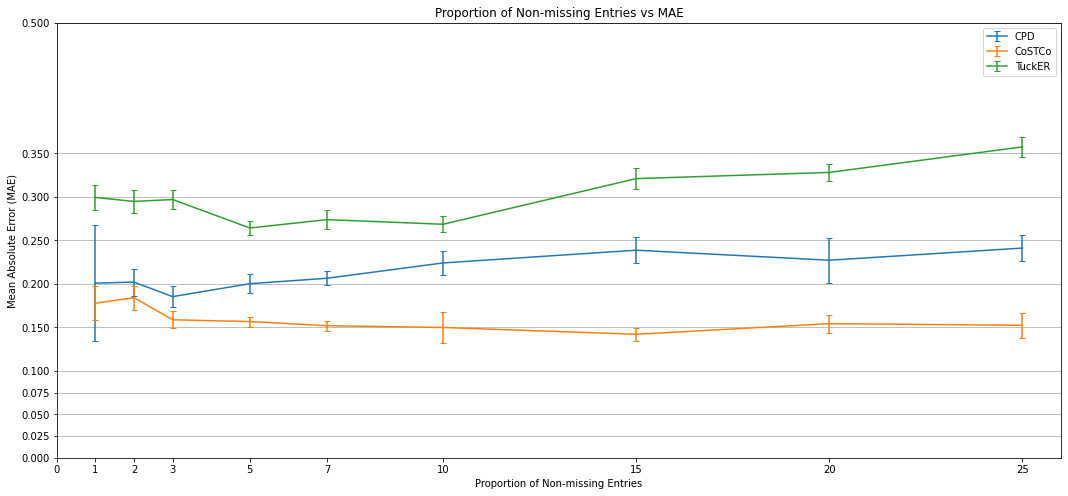

In [16]:
x = ranks

plt.figure(figsize=(18, 8))

for i in range(len(avgs)):
    plt.errorbar(x, avgs[i], yerr=sds[i], label=labels[i], capsize=3)

plt.xlabel('Proportion of Non-missing Entries')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([0]+[t for t in ranks])
plt.yticks([0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5])

plt.title(f'Proportion of Non-missing Entries vs MAE')
plt.legend()
plt.grid(axis='y')

plt.xlim(0, ranks[-1]+1)
# plt.ylim(0.1, 0.2)
# plt.ylim(0, 0.25)
plt.ylim(bottom = 0)

plt.show()